In [72]:
import numpy as np
import fitsio
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from time import time
import sys

# sys.path.append('/global/homes/j/jmccull/sompz/')
# from sompz import SelfOrganizingMap
# from sompz import *
# from sompz.som import *

sys.path.append('/pscratch/sd/j/jmccull/spec_surveys/4C3R2/DESI/')
from myutils.som import *
from myutils.io import *
from myutils.plot import *
#kernel desi-ia

# Read in a fiber assign catalog and characterize

In [5]:
deep_dir = '/pscratch/sd/j/jmccull/desi_deep/'
cat = fitsio.read(deep_dir + 'tertiary-targets-9999-assignv2.fits',ext=1)
print(cat.shape)
print(cat.dtype.names)
print([(col, cat[col].shape) for col in cat.dtype.names])
cols_to_keep = ['RA','DEC','I_MAG','SUCCESS_PROB','NASSIGN','NGOAL','EXP_TIME','SUBPRIORITY']
cat = cat[cols_to_keep]

(29733,)
('RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'OVERRIDE', 'I_MAG', 'TERTIARY_TARGET', 'AVAIL', 'NAVAIL', 'TARGETID', 'SUBPRIORITY', 'CHECKER', 'NGOAL', 'FIBERS', 'ASSIGN', 'NASSIGN', 'EXP_TIME', 'SUCCESS_PROB')
[('RA', (29733,)), ('DEC', (29733,)), ('PMRA', (29733,)), ('PMDEC', (29733,)), ('REF_EPOCH', (29733,)), ('OVERRIDE', (29733,)), ('I_MAG', (29733,)), ('TERTIARY_TARGET', (29733,)), ('AVAIL', (29733, 95)), ('NAVAIL', (29733,)), ('TARGETID', (29733,)), ('SUBPRIORITY', (29733,)), ('CHECKER', (29733,)), ('NGOAL', (29733,)), ('FIBERS', (29733, 95)), ('ASSIGN', (29733, 95)), ('NASSIGN', (29733,)), ('EXP_TIME', (29733,)), ('SUCCESS_PROB', (29733,))]


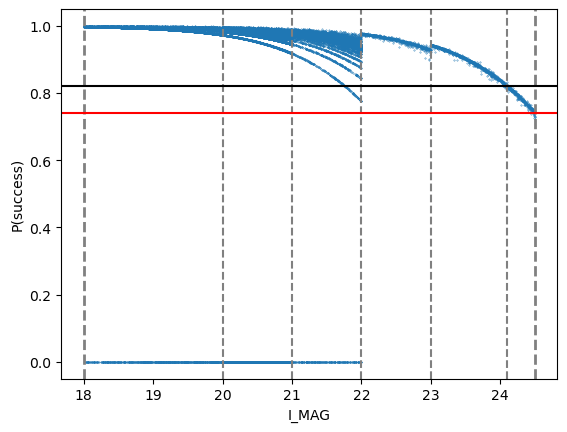

In [22]:
plt.plot(cat['I_MAG'], cat['SUCCESS_PROB'],'o',markersize=0.3,alpha=1.0)
plt.xlabel('I_MAG')
plt.ylabel('P(success)')
plt.axvline(x=24.5,linestyle='dashed',color='gray',linewidth=2)
plt.axvline(x=23.0,linestyle='dashed',color='gray')
plt.axvline(x=22.0,linestyle='dashed',color='gray')
plt.axvline(x=21.0,linestyle='dashed',color='gray')
plt.axvline(x=20.0,linestyle='dashed',color='gray')
plt.axvline(x=24.1,linestyle='dashed',color='gray')

plt.axvline(x=18.0,linestyle='dashed',color='gray',linewidth=2)
plt.axhline(y=0.74,color='red')
plt.axhline(y=0.82,color='black')

plt.show()

In [18]:
mask = cat['NGOAL'] <= cat['NASSIGN'] #recalc to use sum of success probabilities per mag
print(np.sum(mask))

24297


In [24]:
# read in the full targeting post selection flag, pre-downsampling
cosmos_deep_fname = '/pscratch/sd/j/jmccull/desi_deep/target_selection/TEST1_COSMOS_LSSTY1_target_list_unresampled.fits'
cat_full = fitsio.read(cosmos_deep_fname,ext=1)
print(cat_full.shape)
print(cat_full.dtype.names)

(1738696,)
('RA', 'DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'OVERRIDE', 'I_MAG')


In [54]:
#also read in COSMOS photometry in the field with 9-band photometry the matched catalog Dan passed Daniel:
cosmos = fitsio.read("/pscratch/sd/j/jmccull/spec_surveys/4C3R2/SOM/cosmos_matched_som_for_danielg.fits",ext=1)
print(cosmos.shape)
print(cosmos.dtype.names)
print([(col, cosmos[col].shape) for col in cosmos.dtype.names])

(323192,)
('ID', 'XP', 'YP', 'RA', 'DEC', 'R2', 'R2_LAIGLE', 'I_FLAG', 'K_FLAG', 'SOURCE', 'UTOT', 'GTOT', 'RTOT', 'ITOT_1', 'ZTOT', 'YTOT', 'JTOT', 'HTOT', 'KSTOT', 'UTERR', 'GTERR', 'RTERR', 'ITERR', 'ZTERR', 'YTERR', 'JTERR', 'HTERR', 'KSTERR', 'U', 'G', 'R', 'I', 'Z', 'Y', 'J', 'H', 'KS', 'UERR', 'GERR', 'RERR', 'IERR', 'ZERR', 'YERR', 'JERR', 'HERR', 'KSERR', 'E_B_V_', 'RIZ', 'RIZERR', 'INSTR', 'PHOTZ', 'CELLINDEX', 'CELLX', 'CELLY', 'SEP', 'HOUR', 'MINUTE', 'SECOND', 'DEGREE', 'AMIN', 'ASEC')
[('ID', (323192,)), ('XP', (323192,)), ('YP', (323192,)), ('RA', (323192,)), ('DEC', (323192,)), ('R2', (323192,)), ('R2_LAIGLE', (323192,)), ('I_FLAG', (323192,)), ('K_FLAG', (323192,)), ('SOURCE', (323192,)), ('UTOT', (323192,)), ('GTOT', (323192,)), ('RTOT', (323192,)), ('ITOT_1', (323192,)), ('ZTOT', (323192,)), ('YTOT', (323192,)), ('JTOT', (323192,)), ('HTOT', (323192,)), ('KSTOT', (323192,)), ('UTERR', (323192,)), ('GTERR', (323192,)), ('RTERR', (323192,)), ('ITERR', (323192,)), ('ZTE

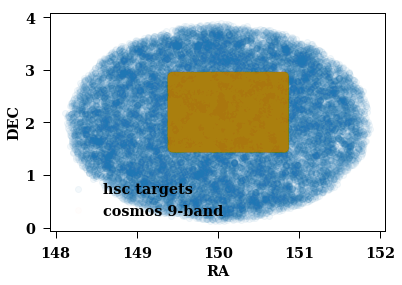

In [47]:
#compare footprints
plt.plot(cat['RA'],cat['DEC'],'o',alpha=0.05,label='hsc targets')
plt.plot(cosmos['RA'],cosmos['DEC'],'o',alpha=0.01,label='cosmos 9-band')

plt.xlabel('RA')
plt.ylabel('DEC')
plt.legend(loc='lower left')
plt.show()

In [55]:
#match them together
start = time()
matched_targets = match_small2large(cosmos,cat_full,smallcols=['RA','DEC'],largecols=['RA','DEC'],acc_err=1.0/3600.,
                                         dfstat=[False,False])
print('time elapsed: {}'.format(time()-start))

matching now, making KDTree....
(1738696, 2)
made KDTree, now trying to take dataframe of size:
(323192,)
to dataframe of size:
(1738696,)
using an acceptable error of 1.0"
We have 215271 matches out of 323192 objects
Total fraction kept after matching: 0.6660777494492438
combining two arrays...
finished!
time elapsed: 1.788259506225586


In [67]:
print(0.2*float(len(cat_full))/(len(matched_targets)))

1.6153555286127719


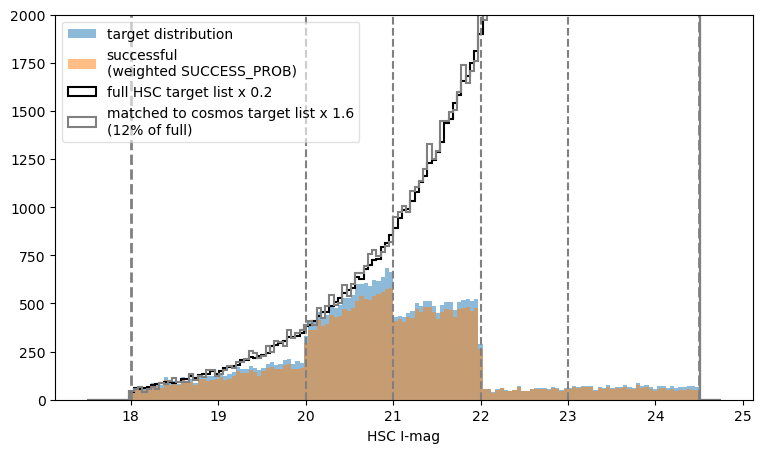

In [92]:
plt.figure(figsize=(9,5))
plt.hist(cat['I_MAG'],bins=np.linspace(17.5,24.75,num=150),alpha=0.5, label='target distribution')
plt.hist(cat['I_MAG'],bins=np.linspace(17.5,24.75,num=150),alpha=0.5,label='successful\n(weighted SUCCESS_PROB)',weights=cat['SUCCESS_PROB'])
plt.hist(cat_full['I_MAG'], bins=np.linspace(17.5,24.75,num=150), color='black',histtype='step',linewidth=1.5,alpha=1.0,label='full HSC target list x 0.2',
         density=False, weights=0.2*np.ones(len(cat_full['I_MAG'])))

plt.hist(matched_targets['I_MAG'], bins=np.linspace(17.5,24.75,num=150), color='gray',histtype='step',linewidth=1.5,alpha=1.0,label='matched to cosmos target list x 1.6\n(12% of full)',
         density=False, weights=1.6*np.ones(len(matched_targets['I_MAG'])))

plt.xlabel('HSC I-mag')
plt.axvline(x=24.5,linestyle='dashed',color='gray',linewidth=2)
plt.axvline(x=23.0,linestyle='dashed',color='gray')
plt.axvline(x=22.0,linestyle='dashed',color='gray')
plt.axvline(x=21.0,linestyle='dashed',color='gray')
plt.axvline(x=20.0,linestyle='dashed',color='gray')
plt.axvline(x=18.0,linestyle='dashed',color='gray',linewidth=2)
plt.legend(loc='upper left',frameon=True, framealpha=0.6)
plt.ylim([0,2000])
plt.show()

# Mock up SOM coverage based on i-band selections
We have a limited overlap area with existing 9-band photometry, but with extended photometry (as we'll eventually have with LSST/Euclid), we can mock up relevance for Stage III and Stage IV separately (restricting to COSMOS, or allowing larger COSMOS footprint + XMM)

# Look at SOM coverage of the matched sample

In [78]:
def format_cell_props(unqcells,prop,shp=(150,75)):
    #function takes unique cell ids and property vectors and reshapes it into a SOM array that is NaN where undefined, for plotting
    output = np.ones(shp[0]*shp[1])*np.NaN
    for i,c in enumerate(unqcells):
        output[c] = prop[i]
        
    return np.reshape(output,shp)

def get_coverage(cellids,shp=(150,75)):
    #get cell occupancy, return SOM object formatted correctly
    unqcells, cts = np.unique(cellids,return_counts=True)
    output = format_cell_props(unqcells,cts,shp=shp)
    output[np.isnan(output)] = 0 #its occupancy, so this is valid
    return output

/tmp/ipykernel_469928/1177210343.py:13: RuntimeWarning: divide by zero encountered in divide
  img = ax[2].imshow(occup_cosmos/occup,origin='lower',interpolation='nearest',cmap='binary',vmin=0,vmax=5)
/tmp/ipykernel_469928/1177210343.py:13: RuntimeWarning: invalid value encountered in divide
  img = ax[2].imshow(occup_cosmos/occup,origin='lower',interpolation='nearest',cmap='binary',vmin=0,vmax=5)


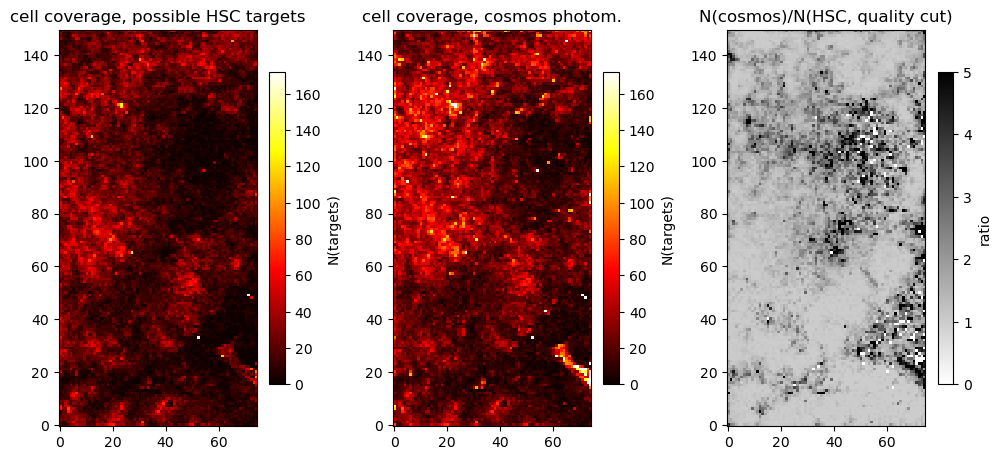

In [91]:
occup = get_coverage(matched_targets['CELLINDEX'])
occup_cosmos = get_coverage(cosmos['CELLINDEX'])

fig,ax = plt.subplots(1,3,figsize=(10,5))
img = ax[0].imshow(occup,origin='lower',interpolation='nearest',cmap='hot')
ax[0].set_title('cell coverage, possible HSC targets')
plt.colorbar(img, ax=ax[0],label='N(targets)',shrink=0.7)

img = ax[1].imshow(occup_cosmos,origin='lower',interpolation='nearest',cmap='hot',vmin=0,vmax=np.max(occup))
ax[1].set_title('cell coverage, cosmos photom.')
plt.colorbar(img, ax=ax[1],label='N(targets)',shrink=0.7)

img = ax[2].imshow(occup_cosmos/occup,origin='lower',interpolation='nearest',cmap='binary',vmin=0,vmax=5)
ax[2].set_title('N(cosmos)/N(HSC, quality cut)')
plt.colorbar(img, ax=ax[2],label='ratio',shrink=0.7)

plt.tight_layout()
plt.show()

# Make a simple SOM for COSMOS and XMM to fill with potential target selections
Deprecated - not enough color information to really disintangle, using COSMOS SOM instead

In [3]:
class SOM:
    def __init__(self, x, y, input_dim, learning_rate=0.5, sigma=6,random_start=False):
        self.x = x
        self.y = y
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.sigma = sigma if sigma is not None else max(x, y) / 2
        if random_start:
            self.weights = np.random.random((x, y, input_dim))
        else:
            self.weights = self._initialize_weights_grid()
        self.history = []
        self.history.append((np.NaN, self.weights.copy()))

    def _initialize_weights_grid(self):
        """Initialize weights in an equidistant grid."""
        # Create a grid of (x, y) coordinates
        xx, yy = np.meshgrid(np.linspace(0, 1, self.x), np.linspace(0, 1, self.y))
        # Flatten the grid coordinates and stack them
        grid = np.stack([xx.ravel(), yy.ravel()], axis=-1)
        # If input_dim > 2, pad the remaining dimensions with zeros
        if self.input_dim > 2:
            grid = np.hstack([grid, np.random.random((self.x * self.y, self.input_dim - 2))])
        # Reshape the grid to (x, y, input_dim)
        return grid.reshape(self.x, self.y, self.input_dim)
        
    @classmethod
    def whiten_data(self,data,mode='linear',verbose=False):
        #will take data and turn it into a 0 to 1 range, and preserve the transformation bounds
        datalims = [np.nanmin(data,axis=0,keepdims=True).T,np.nanmax(data,axis=0,keepdims=True).T]
        if verbose:
            print(datalims[0].shape)
            print(datalims[1].shape)
        assert (datalims[1][:] - datalims[0][:] >= 0).all()
        newdata = np.zeros_like(data)
            
        for i in np.arange(data.shape[1]):
            newdata[:,i] = (data[:,i] - datalims[0][i])/(datalims[1][i]- datalims[0][i])
            mask = np.isnan(newdata[:,i])
            if np.sum(mask) > 0:
                newdata[mask,i] = 0 #set them to the same value
        if mode == 'linear':
            return newdata, datalims
            
        if mode == 'log':
            for i in np.arange(data.shape[1]):
                newdata[:,i] = np.log(data[:,i]) 
            #newdata = newdata + 
        else:
            print("other data modes tbd, for now use 'linear'")
            
            return
        return newdata, datalims
    
    def train(self, data, num_iterations):
        for iteration in range(num_iterations):
            for i, sample in enumerate(data):
                bmu = self._find_bmu(sample)
                self._update_weights(sample, bmu, iteration, num_iterations)
            self.history.append((iteration, self.weights.copy()))
    
    def _find_bmu(self, sample):
        diff = self.weights - sample
        dist = np.linalg.norm(diff, axis=-1)
        return np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    
    @staticmethod
    def find_bmu_custom(weights, sample):
        diff = weights - sample
        dist = np.linalg.norm(diff, axis=-1)
        return np.unravel_index(np.argmin(dist, axis=None), dist.shape)
    
    @staticmethod
    def get_occup(som,weights,samples):
        cells = np.zeros((som.x,som.y))
        for sample in samples:
            idx = SOM.find_bmu_custom(weights,sample)
            cells[idx]=cells[idx]+1
        return cells
    
    def _update_weights(self, sample, bmu, iteration, num_iterations):
        lr = self.learning_rate * (1 - iteration / num_iterations)
        sigma = self.sigma * (1 - iteration / num_iterations)
        bmu_x, bmu_y = bmu
        for x in range(self.x):
            for y in range(self.y):
                dist_to_bmu = np.linalg.norm([x - bmu_x, y - bmu_y])
                if dist_to_bmu <= sigma:
                    influence = np.exp(-dist_to_bmu**2 / (2 * (sigma**2)))
                    self.weights[x, y] += lr * influence * (sample - self.weights[x, y])

In [4]:
# let's train it on HSC photometry:
cosmos_deep_fname = '/global/cfs/cdirs/desi/users/bid13/DESI_II/target_data/HSC_COSMOS_I_mag_lim_24.8.fits'
xmm_deep_fname = '/global/cfs/cdirs/desi/users/bid13/DESI_II/target_data/HSC_XMM_I_mag_lim_24.8.fits'

In [5]:
cosmos_deep = fitsio.read(cosmos_deep_fname,ext=1)
print(cosmos_deep.shape)
print(cosmos_deep.dtype.names)

(2361974,)
('object_id', 'object_id_isnull', 'ra', 'ra_isnull', 'dec', 'dec_isnull', 'g_psfflux_flux', 'g_psfflux_flux_isnull', 'r_psfflux_flux', 'r_psfflux_flux_isnull', 'i_psfflux_flux', 'i_psfflux_flux_isnull', 'z_psfflux_flux', 'z_psfflux_flux_isnull', 'y_psfflux_flux', 'y_psfflux_flux_isnull', 'g_psfflux_fluxerr', 'g_psfflux_fluxerr_isnull', 'r_psfflux_fluxerr', 'r_psfflux_fluxerr_isnull', 'i_psfflux_fluxerr', 'i_psfflux_fluxerr_isnull', 'z_psfflux_fluxerr', 'z_psfflux_fluxerr_isnull', 'y_psfflux_fluxerr', 'y_psfflux_fluxerr_isnull', 'g_cmodel_flux', 'g_cmodel_flux_isnull', 'r_cmodel_flux', 'r_cmodel_flux_isnull', 'i_cmodel_flux', 'i_cmodel_flux_isnull', 'z_cmodel_flux', 'z_cmodel_flux_isnull', 'y_cmodel_flux', 'y_cmodel_flux_isnull', 'g_cmodel_fluxerr', 'g_cmodel_fluxerr_isnull', 'r_cmodel_fluxerr', 'r_cmodel_fluxerr_isnull', 'i_cmodel_fluxerr', 'i_cmodel_fluxerr_isnull', 'z_cmodel_fluxerr', 'z_cmodel_fluxerr_isnull', 'y_cmodel_fluxerr', 'y_cmodel_fluxerr_isnull', 'g_fiber_flux',

0


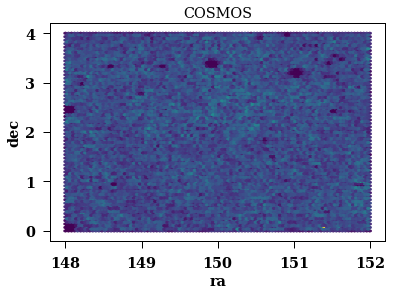

In [6]:
mask = (cosmos_deep['g_mask_brightstar_any'])&(cosmos_deep['r_mask_brightstar_any'])&(cosmos_deep['i_mask_brightstar_any'])&(cosmos_deep['z_mask_brightstar_any'])&(cosmos_deep['y_mask_brightstar_any'])
#& (cosmos_deep['g_mask_brightstar_halo'])& (cosmos_deep['g_mask_brightstar_dip'])& (cosmos_deep['g_mask_brightstar_ghost'])& (cosmos_deep['g_mask_brightstar_blooming'])
print(np.sum(~mask)/len(mask))
plt.hexbin(cosmos_deep[~mask]['ra'],cosmos_deep[~mask]['dec'])
plt.title('COSMOS')
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

cosmos_deep = cosmos_deep[mask]

(2331230,)
('object_id', 'object_id_isnull', 'ra', 'ra_isnull', 'dec', 'dec_isnull', 'g_psfflux_flux', 'g_psfflux_flux_isnull', 'r_psfflux_flux', 'r_psfflux_flux_isnull', 'i_psfflux_flux', 'i_psfflux_flux_isnull', 'z_psfflux_flux', 'z_psfflux_flux_isnull', 'y_psfflux_flux', 'y_psfflux_flux_isnull', 'g_psfflux_fluxerr', 'g_psfflux_fluxerr_isnull', 'r_psfflux_fluxerr', 'r_psfflux_fluxerr_isnull', 'i_psfflux_fluxerr', 'i_psfflux_fluxerr_isnull', 'z_psfflux_fluxerr', 'z_psfflux_fluxerr_isnull', 'y_psfflux_fluxerr', 'y_psfflux_fluxerr_isnull', 'g_cmodel_flux', 'g_cmodel_flux_isnull', 'r_cmodel_flux', 'r_cmodel_flux_isnull', 'i_cmodel_flux', 'i_cmodel_flux_isnull', 'z_cmodel_flux', 'z_cmodel_flux_isnull', 'y_cmodel_flux', 'y_cmodel_flux_isnull', 'g_cmodel_fluxerr', 'g_cmodel_fluxerr_isnull', 'r_cmodel_fluxerr', 'r_cmodel_fluxerr_isnull', 'i_cmodel_fluxerr', 'i_cmodel_fluxerr_isnull', 'z_cmodel_fluxerr', 'z_cmodel_fluxerr_isnull', 'y_cmodel_fluxerr', 'y_cmodel_fluxerr_isnull', 'g_fiber_flux',

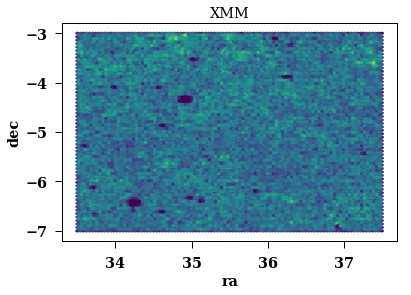

In [7]:
xmm_deep = fitsio.read(xmm_deep_fname,ext=1)
print(xmm_deep.shape)
print(xmm_deep.dtype.names)
mask = (xmm_deep['g_mask_brightstar_any'])&(xmm_deep['r_mask_brightstar_any'])&(xmm_deep['i_mask_brightstar_any'])&(xmm_deep['z_mask_brightstar_any'])&(xmm_deep['y_mask_brightstar_any'])

print(np.sum(~mask)/len(mask))
plt.hexbin(xmm_deep[~mask]['ra'],xmm_deep[~mask]['dec'])
plt.title('XMM')
plt.xlabel('ra')
plt.ylabel('dec')
plt.show()

xmm_deep = xmm_deep[mask]

# Now find the photometry to train a SOM
We have:
- 

/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


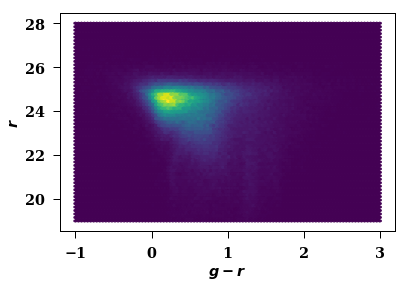

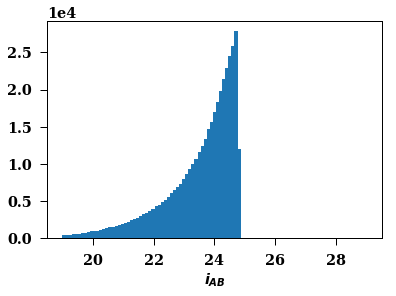

In [8]:
def abmags_nanojy(fluxes,zp=31.4):
    return zp - 2.5*np.log10(fluxes)
lims = (-1,3,19,28)
plt.hexbin(abmags_nanojy(xmm_deep['g_cmodel_flux']) - abmags_nanojy(xmm_deep['r_cmodel_flux']), abmags_nanojy(xmm_deep['r_cmodel_flux']),extent=lims)
plt.xlabel(r'$g - r$')
plt.ylabel(r'$r$')
plt.show()
plt.hist(abmags_nanojy(xmm_deep['i_cmodel_flux']),bins=np.linspace(19,29,num=100))
plt.xlabel(r'$i_{AB}$')
plt.show()

In [12]:
bands = ['g','r','i','z','y']
hsc_fluxcols = [band + '_cmodel_flux'for band in bands]
magcols = [band+'_mag' for band in bands]

hsc_fluxerrcols = [band + '_cmodel_fluxerr'for band in bands]
magerr = [band + '_magerr' for band in bands]

hsc_xmm_df = pd.DataFrame(xmm_deep.byteswap().newbyteorder(),columns=xmm_deep.dtype.names)

def get_mag_err(fluxerr,flux):
    snr = flux/fluxerr
    return (2.5/2.3)/snr

for i,band in enumerate(bands):
    print(i,band)
    hsc_xmm_df[magcols[i]] = abmags_nanojy(hsc_xmm_df[hsc_fluxcols[i]].values)
    hsc_xmm_df[magerr[i]] = get_mag_err(hsc_xmm_df[hsc_fluxerrcols[i]].values,hsc_xmm_df[hsc_fluxcols[i]].values)
    hsc_xmm_df[band + 'mag_ivar'] = 1/hsc_xmm_df[magerr[i]]**2
    
print(hsc_xmm_df.columns)

(0, 'g')
(1, 'r')
(2, 'i')
(3, 'z')
(4, 'y')
Index([u'object_id', u'object_id_isnull', u'ra', u'ra_isnull', u'dec',
       u'dec_isnull', u'g_psfflux_flux', u'g_psfflux_flux_isnull',
       u'r_psfflux_flux', u'r_psfflux_flux_isnull',
       ...
       u'rmag_ivar', u'i_mag', u'i_magerr', u'imag_ivar', u'z_mag',
       u'z_magerr', u'zmag_ivar', u'y_mag', u'y_magerr', u'ymag_ivar'],
      dtype='object', length=287)


/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in divide
  if sys.path[0] == '':


In [13]:
hsc_xmm_df

,object_id,object_id_isnull,ra,ra_isnull,dec,dec_isnull,g_psfflux_flux,g_psfflux_flux_isnull,r_psfflux_flux,r_psfflux_flux_isnull,...,rmag_ivar,i_mag,i_magerr,imag_ivar,z_mag,z_magerr,zmag_ivar,y_mag,y_magerr,ymag_ivar
0,36420386367222995,False,33.518648,False,-6.412665,False,808.848511,False,1115.296631,False,...,775.017578,22.787394,0.022414,1990.483032,22.457909,0.039320,646.793640,22.708813,0.096202,108.051613
1,36420394957161852,False,33.509134,False,-5.987075,False,167.254211,False,234.576324,False,...,22.906618,24.481548,0.051466,377.541901,24.253897,0.090543,121.981171,23.639736,0.122002,67.183571
2,36424634089881541,False,35.059176,False,-6.866507,False,1735.107056,False,6169.938965,False,...,11266.391602,21.115742,0.005430,33921.164062,20.793383,0.007343,18544.498047,20.658108,0.015218,4317.942871
3,36424638384847089,False,35.038240,False,-6.757763,False,253.415344,False,167.312424,False,...,10.310637,24.381847,0.124920,64.081711,23.277456,0.082736,146.087158,22.685715,0.161990,38.108513
4,36424646974785874,False,35.022919,False,-6.356621,False,408.300446,False,650.170715,False,...,341.880615,23.556566,0.036182,763.880920,23.691814,0.095608,109.399185,23.432091,0.166963,35.872410
5,36424646974787283,False,35.052156,False,-6.323747,False,362.007935,False,555.354126,False,...,189.593658,23.726683,0.032501,946.659973,23.373264,0.053495,349.437164,23.353699,0.129101,59.998962
6,36424646974789354,False,35.019848,False,-6.275541,False,490.997284,False,735.535889,False,...,256.337128,23.725954,0.064070,243.606003,23.613636,0.103683,93.022713,24.024105,0.313461,10.177322
7,36424646974790201,False,35.018313,False,-6.255265,False,298.002533,False,892.385559,False,...,448.070984,23.398232,0.025831,1498.686401,23.090652,0.039791,631.569946,22.880272,0.076548,170.661606
8,36424651269739250,False,35.015372,False,-6.111596,False,289.675720,False,404.931458,False,...,139.824570,24.075869,0.064574,239.820496,23.938581,0.130431,58.781219,24.183584,0.369846,7.310695
9,36424651269753478,False,35.048696,False,-6.159067,False,485.664520,False,611.112732,False,...,265.384247,23.968462,0.041990,567.170715,23.754564,0.083917,142.004120,23.706411,0.204562,23.897425


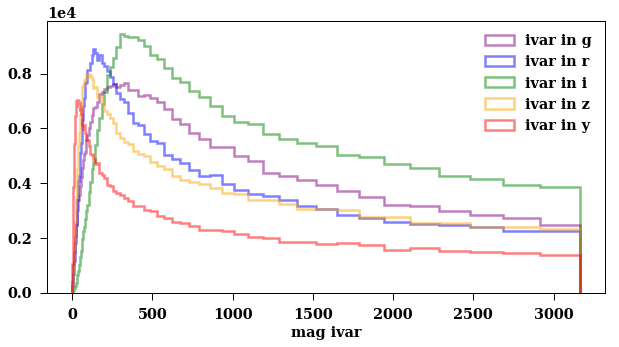

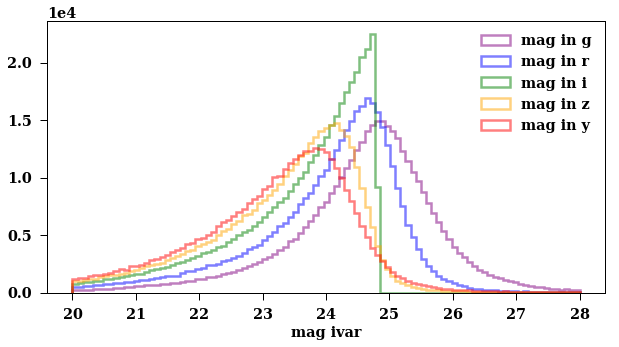

In [14]:
colors = ['purple','blue','green','orange','red']
plt.figure(figsize=(10,5))
for i,band in enumerate(bands):
    plt.hist(hsc_xmm_df[band+'mag_ivar'],alpha=0.5,histtype='step',bins=np.logspace(0,3.5,num=100),linewidth=2.5,color=colors[i],label = 'ivar in ' + band)
plt.xlabel('mag ivar')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10,5))
for i,band in enumerate(bands):
    plt.hist(hsc_xmm_df[band+'_mag'],alpha=0.5,histtype='step',bins=np.linspace(20,28,num=100),linewidth=2.5,color=colors[i],label = 'mag in ' + band)
plt.xlabel('mag ivar')
plt.legend(loc='upper right')
plt.show()

In [24]:
cols = [band +'_mag' for band in bands]
ivar_cols = [band+'mag_ivar' for band in bands]

#randomly sample the HSC data:
rand_ind = np.random.randint(0, len(hsc_xmm_df), size=1000, dtype=int).astype(int)


convert_dict = {'g_mag': float, 
                'r_mag': float, 
                'i_mag': float, 
                'z_mag': float, 
                'y_mag': float,
                'gmag_ivar': float, 
                'rmag_ivar': float, 
                'imag_ivar': float, 
                'zmag_ivar': float, 
                'ymag_ivar': float 
               } 
hsc_xmm_df.astype(convert_dict,inplace=True)
somvals = hsc_xmm_df.iloc[rand_ind][cols]
som_ivar = hsc_xmm_df.iloc[rand_ind][ivar_cols]
data = hsc_xmm_df.iloc[rand_ind][cols+ivar_cols]

color_frame = convert_catalog_to_color_array(data,cols,ivar_cols)
print(len(color_frame))
print(np.shape(color_frame[0]))

color_frame = np.hstack([color_frame[0],color_frame[1]])

#sompz is causing problems, let's just do my simple som
som = SOM(x=10, y=10, input_dim=color_frame.shape[1], random_start=True)

#whiten the data
print(color_frame.shape)
data_one,datalims = som.whiten_data(color_frame,mode='linear',verbose=True)
print(data_one)

converting g_mag - r_mag
converting r_mag - i_mag
converting i_mag - z_mag
converting z_mag - y_mag
2
(1000, 5)
(1000, 10)
(10, 1)
(10, 1)
[[9.68159589e-01 9.38613065e-01 9.79182488e-01 ... 3.61233852e-04
  1.77836579e-04 0.00000000e+00]
 [9.78723060e-01 9.46460327e-01 9.83944872e-01 ... 1.70933644e-03
  1.87503987e-03 0.00000000e+00]
 [9.69233040e-01 9.36666724e-01 9.78304674e-01 ... 2.30707512e-04
  1.50974064e-04 0.00000000e+00]
 ...
 [9.66148250e-01 9.38297790e-01 9.78906654e-01 ... 5.07713447e-04
  2.90235969e-04 0.00000000e+00]
 [9.75025777e-01 9.49626171e-01 9.83462939e-01 ... 2.41512584e-02
  3.47420684e-02 0.00000000e+00]
 [9.71095383e-01 9.37123738e-01 9.78155022e-01 ... 1.17107983e-04
  9.63095918e-05 0.00000000e+00]]


/global/u1/j/jmccull/.conda/envs/imsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in divide


In [25]:
start = time() #train the custom som with a small test
som.train(data_one, num_iterations=500)
print('time elapsed: {}'.format(time()-start))    

time elapsed: 482.666806936


In [26]:
#look at the occupancy for a simple 10 by 10 som

#at the start:
it,weights = som.history[0]
#print(weights)
occup = som.get_occup(som,weights,data)
plt.imshow(occup.reshape(10,10))
plt.title('before training')
plt.show()

it,weights = som.history[1]
#print(weights)
occup = som.get_occup(som,weights,data)
plt.imshow(occup.reshape(10,10))
plt.title('middle training')
plt.show()

#at the end
it,weights = som.history[-1]
occup = som.get_occup(som,weights,data)

plt.imshow(occup.reshape(10,10))
plt.title('after training')
plt.show()

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('S32') dtype('S32') dtype('S32')

In [ ]:
#som = train_som(somvals, som_ivar, map_shape=[10, 10], learning_rate=0.5, max_iter=1e3, min_val=1e-4, verbose=True, diag_ivar=False, replace=False)
"""Calculate Self Organizing Map

Parameters
----------
x :             input data of shape (n_samples, n_dim)
ivar :          inverse variance of input data (n_samples, n_dim, n_dim)
map_shape :     desired output map shape = [dim1, dim2]. (n_out_dim,)
learning_rate : float usually between 0 and 1. Sets how large of a
                change we can effect in the weights at each step by
                multiplying the change by:
                    learning_rate ** (step_t / total_t)
max_iter :      maximum number of steps in algorithm fit
min_val :       minimum parameter difference we worry about in updating
                SOM. This in practice usually doesn't come up, as we limit
                the range of cells a SOM may update to be less than one
                wrap around the map.
verbose :       Print updates?

Returns
-------
w : self organizing map weights (dim1, dim2, n_dims)

Notes
-----
Suggest whitening your data to span 0-1 range before training

"""

time elapsed: 7700.63557005


"Calculate Self Organizing Map\n\nParameters\n----------\nx :             input data of shape (n_samples, n_dim)\nivar :          inverse variance of input data (n_samples, n_dim, n_dim)\nmap_shape :     desired output map shape = [dim1, dim2]. (n_out_dim,)\nlearning_rate : float usually between 0 and 1. Sets how large of a\n                change we can effect in the weights at each step by\n                multiplying the change by:\n                    learning_rate ** (step_t / total_t)\nmax_iter :      maximum number of steps in algorithm fit\nmin_val :       minimum parameter difference we worry about in updating\n                SOM. This in practice usually doesn't come up, as we limit\n                the range of cells a SOM may update to be less than one\n                wrap around the map.\nverbose :       Print updates?\n\nReturns\n-------\nw : self organizing map weights (dim1, dim2, n_dims)\n\nNotes\n-----\nSuggest whitening your data to span 0-1 range before training\n

In [ ]:
som